# Imports

In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


# Reading Data

In [2]:
hist = pd.read_csv('data.csv').dropna()
target_col = 'Close'
#inputs = hist.drop(columns=['DateTime'])
hist = hist.set_index('DateTime')
#labels = inputs['Close']
#inputs = inputs.drop(columns=['Close'])

In [19]:
mytest = hist.iloc[454650:]
hist = hist.iloc[:454650]

# Data Visualization

In [20]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [21]:
train, test = train_test_split(hist, test_size=0.2)

In [54]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=1):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    #plt.xticks(rotation=90)
    plt.xlabel('2019', fontsize=12)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

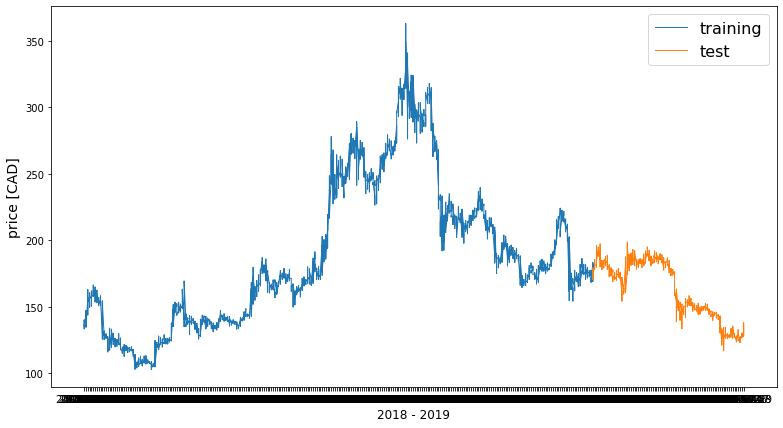

In [23]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

# Model Training

In [24]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [25]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [26]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [27]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [50]:
np.random.seed(42)
window_len = 5
test_size = 0.20
zero_base = True
lstm_neurons = 120
epochs = 44
batch_size = 32
loss = 'mse'
dropout = 0.21
optimizer = 'adam'

In [51]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
#X_train, X_test, y_train, y_test = train_test_split(inputs, hist[target_col], test_size=0.2)

In [35]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle = True)

Epoch 1/44
450099/450099 [==============================] - 87s 194us/step - loss: 3.3955e-04
Epoch 2/44
450099/450099 [==============================] - 86s 191us/step - loss: 3.3816e-05
Epoch 3/44
450099/450099 [==============================] - 87s 193us/step - loss: 3.3365e-05
Epoch 4/44
450099/450099 [==============================] - 86s 192us/step - loss: 3.3006e-05
Epoch 5/44
450099/450099 [==============================] - 86s 191us/step - loss: 3.2705e-05
Epoch 6/44
450099/450099 [==============================] - 86s 191us/step - loss: 3.2597e-05
Epoch 7/44
450099/450099 [==============================] - 86s 191us/step - loss: 3.2901e-05
Epoch 8/44
450099/450099 [==============================] - 86s 191us/step - loss: 3.2617e-05
Epoch 9/44
450099/450099 [==============================] - 86s 191us/step - loss: 3.2429e-05
Epoch 10/44
450099/450099 [==============================] - 86s 191us/step - loss: 3.2615e-05
Epoch 11/44
450099/450099 [==============================] 

# Model Testing

In [52]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.0019906126277360815

[181.96576904 181.98240273 181.96117437 ... 134.54242379 134.52812266
 134.38086153]


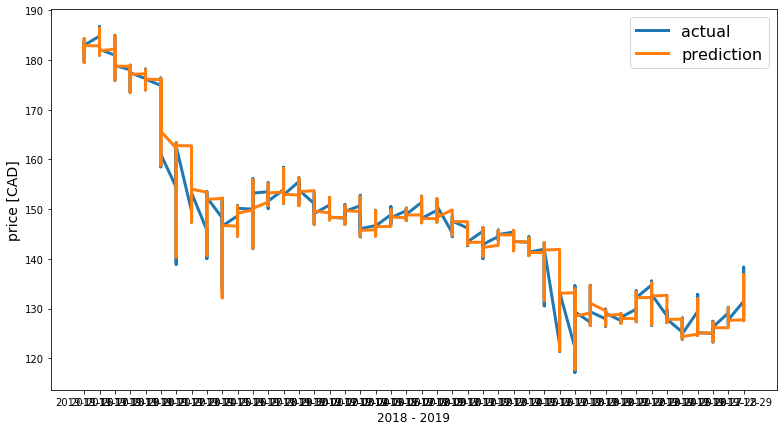

In [53]:
preds = test[target_col].values[:-window_len] * (preds + 1)
print(preds)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [55]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'